In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
from PIL import ImageFilter
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== 1. Multi-modal MNIST dataset ======
class MultiModalMNIST(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.dataset = datasets.MNIST(root="./data", train=train, download=True)
        
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        
        # Modality 1: original
        m1 = TF.to_tensor(img)
        # Modality 2: edge-detected
        m2 = TF.to_tensor(img.filter(ImageFilter.EMBOSS))
        # Modality 3: inverted
        m3 = TF.to_tensor(TF.invert(img.filter(ImageFilter.EMBOSS)))
        
        return (m1, m2, m3), label
    
    def __len__(self):
        return len(self.dataset)

train_loader = torch.utils.data.DataLoader(
    MultiModalMNIST(train=True),
    batch_size=64, shuffle=True
)

# ====== 2. Tiny CNN encoders per modality ======
class TinyEncoder(nn.Module):
    def __init__(self, out_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(16*7*7, out_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# 3 nodes (modalities)
num_modalities = 3
embed_dim = 128
encoders = nn.ModuleList([TinyEncoder(embed_dim).to(device) for _ in range(num_modalities)])


# ====== 3. Restriction maps P_{i->e} and Dual maps Q_{e->i} ======
edges = [(0,1),(0,2),(1,2)]
edge_dim = 64  # shared comparison space

restrictions = nn.ParameterDict()  # P maps
duals = nn.ParameterDict()         # Q maps

for (i,j) in edges:
    # P: node -> edge
    restrictions[f"{i}->{i}-{j}"] = nn.Parameter(torch.randn(edge_dim, embed_dim) * 0.1).to(device)
    restrictions[f"{j}->{i}-{j}"] = nn.Parameter(torch.randn(edge_dim, embed_dim) * 0.1).to(device)

    # Q: edge -> node
    duals[f"{i}-{j}->{i}"] = nn.Parameter(torch.randn(embed_dim, edge_dim) * 0.1).to(device)
    duals[f"{i}-{j}->{j}"] = nn.Parameter(torch.randn(embed_dim, edge_dim) * 0.1).to(device)


# ====== 4. Loss functions ======
def cosine_sim(a, b):
    return F.cosine_similarity(a.unsqueeze(1), b.unsqueeze(0), dim=-1)

def contrastive_loss(p_i, p_j, tau=0.1):
    # p_i, p_j: [B, D]
    sim_ij = cosine_sim(p_i, p_j) / tau
    labels = torch.arange(p_i.size(0)).to(device)
    # Symmetric InfoNCE
    loss_i = F.cross_entropy(sim_ij, labels)
    loss_j = F.cross_entropy(sim_ij.t(), labels)
    return 0.5 * (loss_i + loss_j)

def laplacian_loss(p_i, p_j):
    return ((p_i - p_j)**2).sum(dim=1).mean()

def reconstruction_loss(h_i, p_i, Q_ei):
    # Reconstruct node embedding from edge embedding
    # p_i: node->edge embedding [B, edge_dim]
    # Q_ei: edge->node map [embed_dim, edge_dim]
    recon = p_i @ Q_ei.t()  # [B, embed_dim]
    return F.mse_loss(recon, h_i)



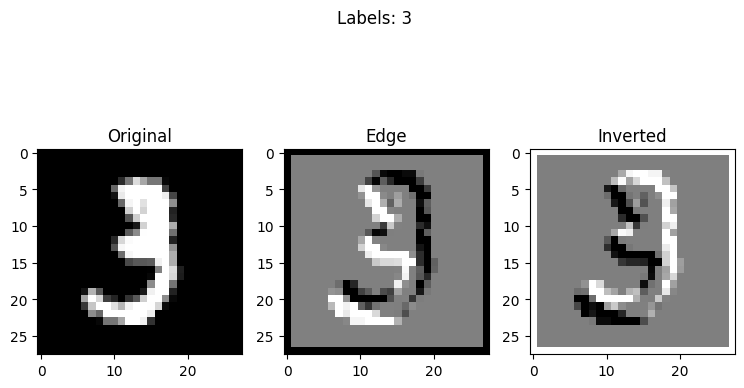

In [5]:
dataset = MultiModalMNIST(train=True)
def show_sample(idx=0):
    (m1, m2, m3), label = dataset[idx]
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    for ax, im, title in zip(axes, [m1, m2, m3], ["Original", "Edge", "Inverted"]):
        ax.imshow(im.squeeze(), cmap="gray")
        ax.set_title(title)

    plt.suptitle(f"Labels: {label}")
    plt.show()

show_sample(10)


In [6]:
# ====== 5. Training loop ======
optimizer = torch.optim.Adam(
    list(encoders.parameters()) + list(restrictions.parameters()) + list(duals.parameters()),
    lr=1e-4
)

lambda_lap = 1.0
beta_contrast = 1.0
gamma_recon = 0.1  # weight for reconstruction loss

for epoch in range(50):  # small demo
    for (mods, labels) in train_loader:
        mods = [m.to(device) for m in mods]
        batch_size = mods[0].size(0)

        # Local embeddings h_i
        h = [enc(mods[i]) for i, enc in enumerate(encoders)]  # list of [B, embed_dim]

        total_loss = 0.0

        # Loop over edges for sheaf contrastive + Laplacian + Reconstruction
        for (i,j) in edges:
            P_i = restrictions[f"{i}->{i}-{j}"]
            P_j = restrictions[f"{j}->{i}-{j}"]
            Q_ei = duals[f"{i}-{j}->{i}"]
            Q_ej = duals[f"{i}-{j}->{j}"]

            p_i = (h[i] @ P_i.t())   # [B, edge_dim]
            p_j = (h[j] @ P_j.t())   # [B, edge_dim]

            lap_loss = laplacian_loss(p_i, p_j)
            contrast_loss = contrastive_loss(p_i, p_j)

            # Reconstruction from edge back to nodes
            recon_loss_i = reconstruction_loss(h[i], p_i, Q_ei)
            recon_loss_j = reconstruction_loss(h[j], p_j, Q_ej)

            
            total_loss += (
                lambda_lap * lap_loss +
                beta_contrast * contrast_loss +
                gamma_recon * (recon_loss_i + recon_loss_j)
            )

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss.item():.4f}")


Epoch 1, Loss: 0.4268
Epoch 2, Loss: 0.2047
Epoch 3, Loss: 0.1158
Epoch 4, Loss: 0.0873
Epoch 5, Loss: 0.1090
Epoch 6, Loss: 0.0690
Epoch 7, Loss: 0.0813
Epoch 8, Loss: 0.0630
Epoch 9, Loss: 0.0510
Epoch 10, Loss: 0.0486
Epoch 11, Loss: 0.0306
Epoch 12, Loss: 0.0389
Epoch 13, Loss: 0.0405
Epoch 14, Loss: 0.0359
Epoch 15, Loss: 0.0348
Epoch 16, Loss: 0.0322
Epoch 17, Loss: 0.0313
Epoch 18, Loss: 0.0243
Epoch 19, Loss: 0.0469
Epoch 20, Loss: 0.0208
Epoch 21, Loss: 0.0211
Epoch 22, Loss: 0.0190
Epoch 23, Loss: 0.0370
Epoch 24, Loss: 0.0236
Epoch 25, Loss: 0.0167
Epoch 26, Loss: 0.0194
Epoch 27, Loss: 0.0201
Epoch 28, Loss: 0.0142
Epoch 29, Loss: 0.0238
Epoch 30, Loss: 0.0243
Epoch 31, Loss: 0.0145
Epoch 32, Loss: 0.0135
Epoch 33, Loss: 0.0149
Epoch 34, Loss: 0.0397
Epoch 35, Loss: 0.0126
Epoch 36, Loss: 0.0146
Epoch 37, Loss: 0.0143
Epoch 38, Loss: 0.0118
Epoch 39, Loss: 0.0146
Epoch 40, Loss: 0.0111
Epoch 41, Loss: 0.0141
Epoch 42, Loss: 0.0133
Epoch 43, Loss: 0.0175
Epoch 44, Loss: 0.01

In [10]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
from PIL import ImageFilter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== 0. Load your trained components ======
# encoders, restrictions, duals, edges should be loaded from your training
# Example:
# from train_multimodal_mnist import encoders, restrictions, duals, edges
embed_dim = 128
edge_dim = 64

# ====== 1. Multi-modal MNIST test dataset ======


test_loader = DataLoader(MultiModalMNIST(train=False), batch_size=256, shuffle=False)

# ====== 2. Encode + Optionally Reconstruct via Dual Maps ======
def encode_modality(modality_idx, loader, use_reconstruction=False):
    enc = encoders[modality_idx].eval()
    embs, labels = [], []
    with torch.no_grad():
        for mods, y in loader:
            x = mods[modality_idx].to(device)
            y = y.to(device)
            h = enc(x)  # [B, embed_dim]

            if use_reconstruction:
                # Aggregate reconstructions from all edges touching this node
                reconstructions = []
                for (i, j) in edges:
                    if modality_idx in (i, j):
                        edge_key = f"{i}-{j}"
                        node_key = f"{modality_idx}->{edge_key}"
                        dual_key = f"{edge_key}->{modality_idx}"
                        P = restrictions[node_key]    # [edge_dim, embed_dim]
                        Q = duals[dual_key]           # [embed_dim, edge_dim]

                        edge_emb = h @ P.t()          # project to edge
                        node_recon = edge_emb @ Q.t() # reconstruct node
                        reconstructions.append(node_recon)

                if len(reconstructions) > 0:
                    h = sum(reconstructions) / len(reconstructions)

            h = F.normalize(h, dim=-1)
            embs.append(h)
            labels.append(y)
    return torch.cat(embs), torch.cat(labels)


# ====== 3. Zero-Shot Learning Evaluation ======
def zero_shot_eval(mod_idx=0, use_reconstruction=False):
    print(f"\n[Zero-Shot Eval] Using modality {mod_idx} embeddings "
          f"{'(reconstructed)' if use_reconstruction else '(raw)'}")
    # Encode all test data
    test_embs, test_labels = encode_modality(mod_idx, test_loader, use_reconstruction)

    # Compute class centroids
    num_classes = 10
    centroids = []
    for c in range(num_classes):
        class_embs = test_embs[test_labels == c]
        centroids.append(class_embs.mean(dim=0))
    centroids = F.normalize(torch.stack(centroids), dim=-1)  # [10, D]

    # Classify by cosine similarity
    sims = test_embs @ centroids.t()  # [N, 10]
    preds = sims.argmax(dim=1)
    acc = (preds == test_labels.to(device)).float().mean().item()
    print(f"Zero-Shot Accuracy (modality {mod_idx}): {acc*100:.2f}%")
    return acc


# ====== 4. Cross-Modal Retrieval ======
def cross_modal_retrieval(query_mod=0, gallery_mod=1, top_k=(1,5,10), use_reconstruction=False):
    print(f"\n[Cross-Modal Retrieval] Query: {query_mod} -> Gallery: {gallery_mod} "
          f"{'(reconstructed)' if use_reconstruction else '(raw)'}")

    q_embs, q_labels = encode_modality(query_mod, test_loader, use_reconstruction)
    g_embs, g_labels = encode_modality(gallery_mod, test_loader, use_reconstruction)

    # Compute cosine similarity
    sim = q_embs @ g_embs.t()
    ranks = sim.argsort(dim=1, descending=True)

    recalls = {k: 0 for k in top_k}
    for i, label in enumerate(q_labels):
        retrieved_labels = g_labels[ranks[i]]
        for k in top_k:
            if label in retrieved_labels[:k]:
                recalls[k] += 1

    for k in top_k:
        recalls[k] /= len(q_labels)
        print(f"Recall@{k}: {recalls[k]*100:.2f}%")
    return recalls


# ====== 5. Run evaluations ======
if __name__ == "__main__":
    # Zero-shot on raw and reconstructed embeddings
    zero_shot_eval(mod_idx=0, use_reconstruction=False)
    zero_shot_eval(mod_idx=0, use_reconstruction=True)

    # Cross-modal retrieval
    cross_modal_retrieval(query_mod=0, gallery_mod=2, use_reconstruction=False)
    cross_modal_retrieval(query_mod=0, gallery_mod=2, use_reconstruction=True)



[Zero-Shot Eval] Using modality 0 embeddings (raw)
Zero-Shot Accuracy (modality 0): 64.93%

[Zero-Shot Eval] Using modality 0 embeddings (reconstructed)
Zero-Shot Accuracy (modality 0): 45.92%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (raw)
Recall@1: 9.63%
Recall@5: 31.07%
Recall@10: 46.93%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (reconstructed)
Recall@1: 10.49%
Recall@5: 33.64%
Recall@10: 49.85%


In [ ]:
# Embeddings 128 
'''
[Zero-Shot Eval] Using modality 0 embeddings (raw)
Zero-Shot Accuracy (modality 0): 67.30%

[Zero-Shot Eval] Using modality 0 embeddings (reconstructed)
Zero-Shot Accuracy (modality 0): 64.59%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (raw)
Recall@1: 11.04%
Recall@5: 31.41%
Recall@10: 45.51%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (reconstructed)
Recall@1: 10.28%
Recall@5: 30.39%
Recall@10: 44.75%
'''



# Embeddings 64

'''
[Zero-Shot Eval] Using modality 0 embeddings (raw)
Zero-Shot Accuracy (modality 0): 75.59%

[Zero-Shot Eval] Using modality 0 embeddings (reconstructed)
Zero-Shot Accuracy (modality 0): 54.00%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (raw)
Recall@1: 8.23%
Recall@5: 25.64%
Recall@10: 38.85%

[Cross-Modal Retrieval] Query: 0 -> Gallery: 2 (reconstructed)
Recall@1: 9.04%
Recall@5: 28.85%
Recall@10: 43.70%

'''

In [11]:
def encode_modality(node_idx, loader):
    embs = {node_idx: {node_idx:[]}}  # Only reconstruct for the given node_idx
    labels = {node_idx: []}

    for node in range(num_modalities):
        encoders[node].eval()

    with torch.no_grad():
        for mods, y in loader:
            mods = [m.to(device) for m in mods]
            y = y.to(device)
            for mod_id, x in enumerate(mods):
                h = encoders[mod_id](x)  # [B, embed_dim]

                if mod_id == node_idx:
                    # Store direct embedding under key 0
                    embs[node_idx][node_idx].append(h)
                    if mod_id == node_idx:
                        labels[node_idx].append(y)
                else:
                    # Reconstruct node_idx embedding from mod_id
                    reconstructions = []
                    for (i, j) in edges:
                        if node_idx in (i, j) and mod_id in (i, j):
                            edge_key = f"{i}-{j}"
                            source_key = f"{mod_id}->{edge_key}"
                            dual_key = f"{edge_key}->{node_idx}"

                            P = restrictions[source_key]  # [edge_dim, embed_dim]
                            Q = duals[dual_key]           # [embed_dim, edge_dim]

                            edge_emb = h @ P.t()          # project to edge
                            recon = edge_emb @ Q.t()      # reconstruct at node_idx
                            reconstructions.append(recon)

                    if len(reconstructions) > 0:
                        recon_total = torch.stack(reconstructions).mean(dim=0)  # or sum
                        if mod_id not in embs[node_idx]:
                            embs[node_idx][mod_id] = []
                        embs[node_idx][mod_id].append(recon_total)

    

    # Concatenate all
    for key in embs[node_idx]:
        embs[node_idx][key] = torch.cat(embs[node_idx][key], dim=0)
    labels[node_idx] = torch.cat(labels[node_idx], dim=0)

    return embs, labels

In [19]:
embs, labels = encode_modality(1, test_loader)

In [20]:
'''
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
node = 2

# Get the 3 sets of embeddings to compare
emb_main   = embs[node][node]  # Directly from encoder at node 1
emb_from_0 = embs[node][0]  # Reconstructed from node 0
emb_from_2 = embs[node][1]  # Reconstructed from node 2

# Concatenate all for t-SNE
X = torch.cat([emb_main, emb_from_0, emb_from_2], dim=0).cpu().numpy()

# Create labels for modalities
modality_labels = (
    [0] * len(emb_main) +      # 0: Direct from node 1
    [1] * len(emb_from_0) +    # 1: Reconstructed from node 0
    [2] * len(emb_from_2)      # 2: Reconstructed from node 2
)
modality_labels = np.array(modality_labels)

# Optionally use the actual digit labels for coloring instead
# all_labels = labels[node].numpy()  # (should match for all three)

# Run t-SNE
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Plot each modality
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
labels_map = ['Direct (node 1)', 'From node 0', 'From node 2']

for mod_id in range(3):
    idx = modality_labels == mod_id
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=labels_map[mod_id], alpha=0.7, color=colors[mod_id])

plt.legend()
plt.title("t-SNE of Embeddings at Node 1 (From Self, Node 0, Node 2)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.grid(True)
plt.show()
'''

'\nimport numpy as np\nfrom sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\nnode = 2\n\n# Get the 3 sets of embeddings to compare\nemb_main   = embs[node][node]  # Directly from encoder at node 1\nemb_from_0 = embs[node][0]  # Reconstructed from node 0\nemb_from_2 = embs[node][1]  # Reconstructed from node 2\n\n# Concatenate all for t-SNE\nX = torch.cat([emb_main, emb_from_0, emb_from_2], dim=0).cpu().numpy()\n\n# Create labels for modalities\nmodality_labels = (\n    [0] * len(emb_main) +      # 0: Direct from node 1\n    [1] * len(emb_from_0) +    # 1: Reconstructed from node 0\n    [2] * len(emb_from_2)      # 2: Reconstructed from node 2\n)\nmodality_labels = np.array(modality_labels)\n\n# Optionally use the actual digit labels for coloring instead\n# all_labels = labels[node].numpy()  # (should match for all three)\n\n# Run t-SNE\nX_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)\n\n# Plot each modality\nplt.figure(figsize=(10, 8))\ncolors

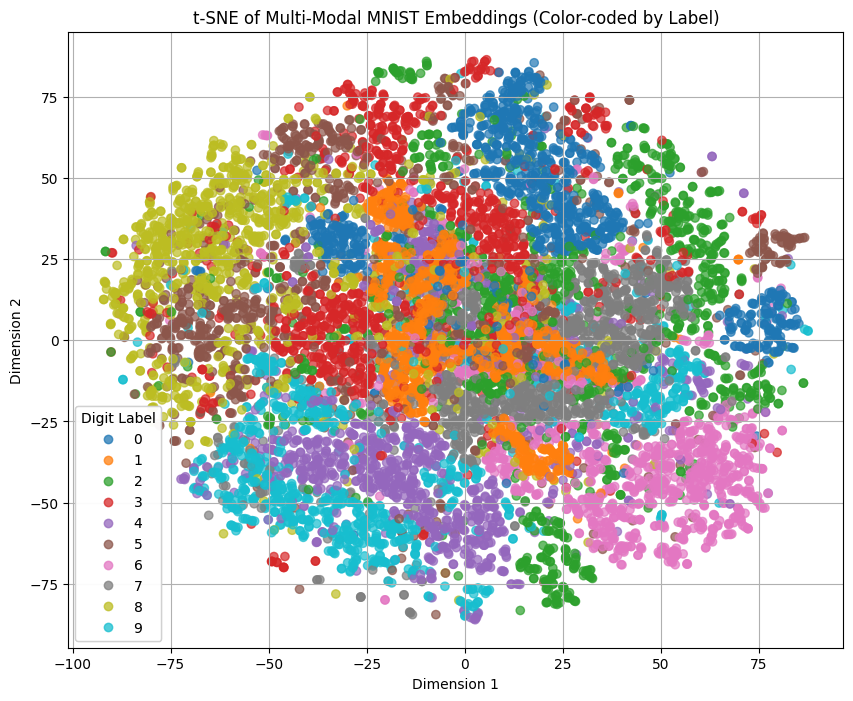

In [21]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
node = 1
all_embeddings = embs[node][0]
all_labels = labels[node]

X = all_embeddings.cpu().numpy()
all_labels = all_labels.cpu().numpy()


# Run t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
X_2d = tsne.fit_transform(X)

# Plotting: Color by digit class (0–9)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
legend = plt.legend(*scatter.legend_elements(), title="Digit Label", loc="best")
plt.gca().add_artist(legend)
plt.title("t-SNE of Multi-Modal MNIST Embeddings (Color-coded by Label)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

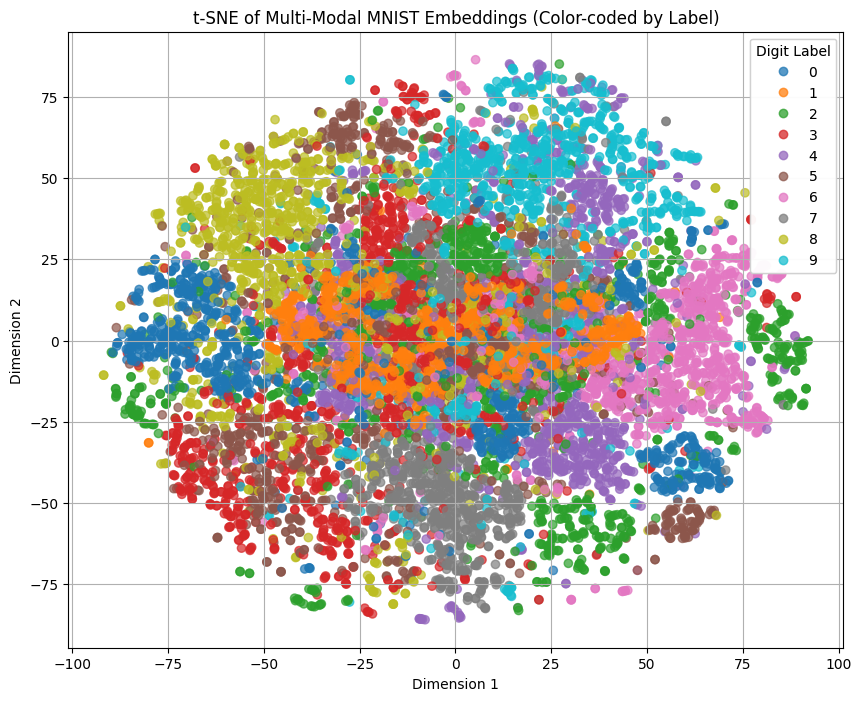

In [28]:
# Combine embeddings and labels
X = embs[node][2].cpu().numpy()
#all_labels = all_labels.cpu().numpy()

# Run t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
X_2d = tsne.fit_transform(X)

# Plotting: Color by digit class (0–9)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
legend = plt.legend(*scatter.legend_elements(), title="Digit Label", loc="best")
plt.gca().add_artist(legend)
plt.title("t-SNE of Multi-Modal MNIST Embeddings (Color-coded by Label)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

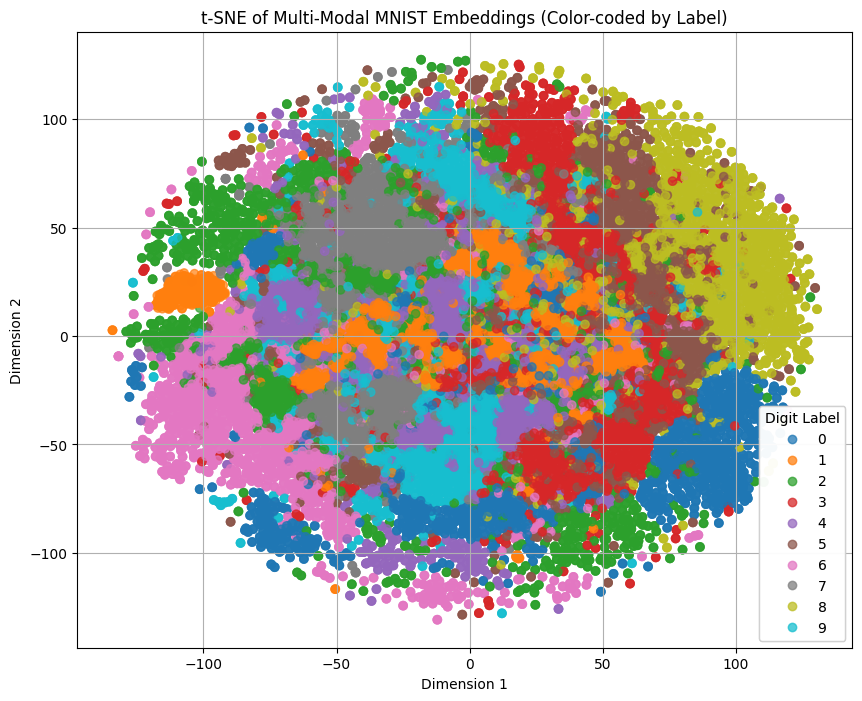

In [30]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
node = 1
all_embeddings = []
all_labels = []

for mod in range(3):
    all_embeddings.extend(embs[node][mod])  # Add all 3 modality embeddings
    all_labels.extend(labels[node])  # Duplicate label 3 times

# Convert to tensors if needed
all_embeddings = torch.stack(all_embeddings)
all_labels = torch.tensor(all_labels)


X = all_embeddings.cpu().numpy()
all_labels = all_labels.cpu().numpy()


# Run t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
X_2d = tsne.fit_transform(X)

# Plotting: Color by digit class (0–9)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
legend = plt.legend(*scatter.legend_elements(), title="Digit Label", loc="best")
plt.gca().add_artist(legend)
plt.title("t-SNE of Multi-Modal MNIST Embeddings (Color-coded by Label)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


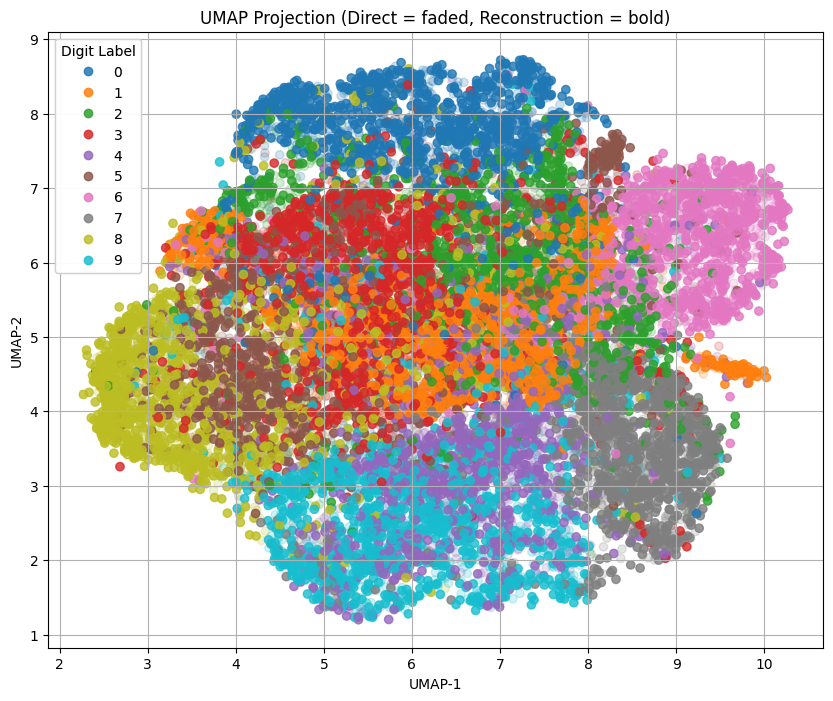

In [31]:
import numpy as np
import umap
import matplotlib.pyplot as plt

node = 1

# === Train UMAP on a reference set (e.g., direct embeddings) ===
reference_embeddings = embs[node][0]  # direct embeddings from node 0
reference_labels = labels[node]

X_ref = reference_embeddings.cpu().numpy()
y_ref = reference_labels.cpu().numpy()

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=0)
X_ref_2d = umap_model.fit_transform(X_ref)

# === Transform other embeddings (e.g., reconstructed from node 1) ===
X_target = embs[node][1].cpu().numpy()
y_target = labels[node].cpu().numpy()

X_target_2d = umap_model.transform(X_target)

# === Plot reference (optional, faded in background) + target ===
plt.figure(figsize=(10, 8))

# Optional: show original embeddings as faded points
plt.scatter(X_ref_2d[:, 0], X_ref_2d[:, 1], c=y_ref, cmap='tab10', alpha=0.2, label="Direct")

# Main: show reconstructed embeddings
scatter = plt.scatter(X_target_2d[:, 0], X_target_2d[:, 1], c=y_target, cmap='tab10', alpha=0.8)
legend = plt.legend(*scatter.legend_elements(), title="Digit Label", loc="best")
plt.gca().add_artist(legend)

plt.title("UMAP Projection (Direct = faded, Reconstruction = bold)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


/usr/local/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


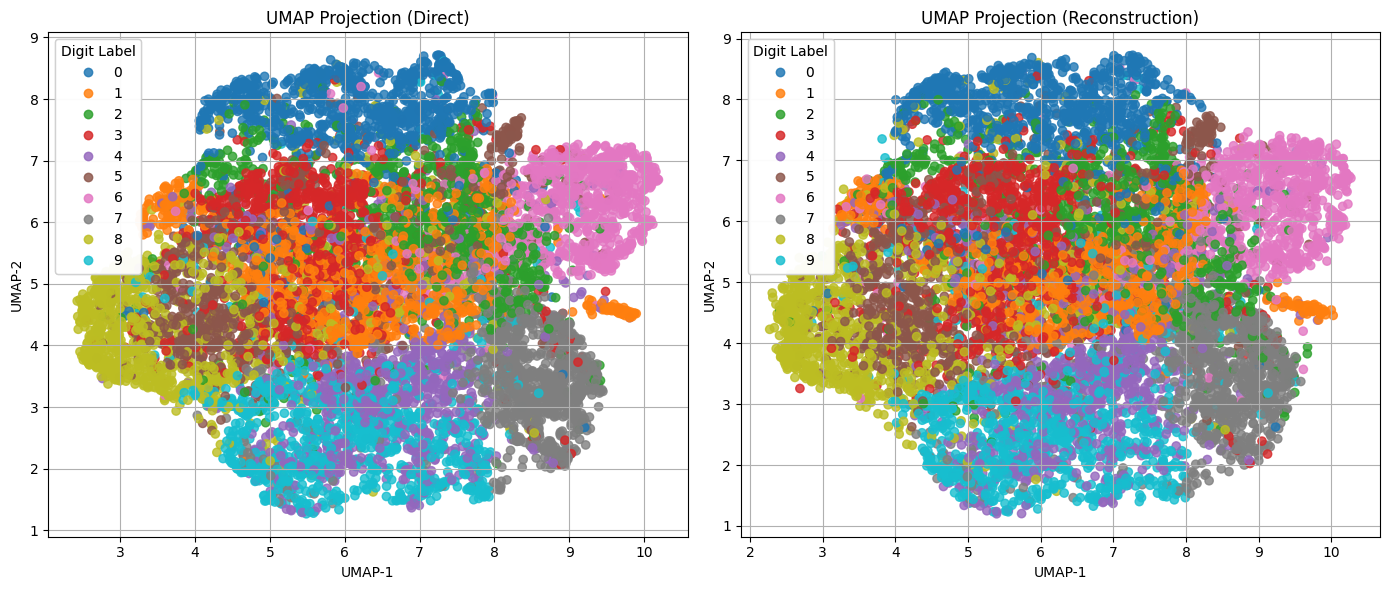

In [32]:
import numpy as np
import umap
import matplotlib.pyplot as plt

node = 1

# === Train UMAP on a reference set (direct embeddings) ===
reference_embeddings = embs[node][0]  # direct embeddings from node 0
reference_labels = labels[node]

X_ref = reference_embeddings.cpu().numpy()
y_ref = reference_labels.cpu().numpy()

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=0
)
X_ref_2d = umap_model.fit_transform(X_ref)

# === Transform other embeddings (reconstructed from node 1) ===
X_target = embs[node][1].cpu().numpy()
y_target = labels[node].cpu().numpy()
X_target_2d = umap_model.transform(X_target)

# === Side-by-side plots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot direct embeddings
sc1 = axes[0].scatter(
    X_ref_2d[:, 0], X_ref_2d[:, 1],
    c=y_ref, cmap='tab10', alpha=0.8
)
axes[0].set_title("UMAP Projection (Direct)")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")
axes[0].grid(True)
legend1 = axes[0].legend(*sc1.legend_elements(), title="Digit Label", loc="best")
axes[0].add_artist(legend1)

# Plot reconstructed embeddings
sc2 = axes[1].scatter(
    X_target_2d[:, 0], X_target_2d[:, 1],
    c=y_target, cmap='tab10', alpha=0.8
)
axes[1].set_title("UMAP Projection (Reconstruction)")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")
axes[1].grid(True)
legend2 = axes[1].legend(*sc2.legend_elements(), title="Digit Label", loc="best")
axes[1].add_artist(legend2)

plt.tight_layout()
plt.show()
